In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import ListedColormap 
from matplotlib import gridspec
# import scienceplots
# plt.style.use(['science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
width = textwidth
height = width * aspect_ratio

In [2]:
from pathlib import Path 
import sys 
import os 
PATH = Path.cwd() 
sys.path.insert(0, str(Path(PATH).parent))

model_save_dir = str(Path(PATH).parent) + '/saved_models'
to_load, model_num = 'adaptable-chimp-787', 204
# 'glamorous-snipe-309', 114
# 'calm-snake-218', '219l'
model_path = os.path.join(model_save_dir, f'{to_load}/{model_num}.pth')

from configs.parsing import get_config_file, set_model_config_based_on_dataset
import argparse 

config_name = 'SRL_1'
config_filename = os.path.join(model_save_dir, f'{to_load}/{config_name}.json')
print('Config File', config_filename)
config_dict = get_config_file(config_filename)
print(config_dict)
d = {**config_dict}
args = argparse.Namespace(**d)

import data 
import models 
data_interface = data.DatasetInterface(args.data.pop('return_type'), **args.data)
args = set_model_config_based_on_dataset(args, data_interface)
model_interface = getattr(models, args.model.pop('object'))(**args.model)

import torch 
if isinstance(model_interface, torch.nn.Module): 
    state_dict = torch.jit.load(model_path, map_location=torch.device('cpu'))
    model_interface.load_state_dict(state_dict.state_dict())
    print('Loaded Module from state_dict')
elif isinstance(model_interface, torch.jit.TorchScript): 
    import io 
    with open(model_path, 'rb') as f:
        buffer = io.BytesIO(f.read())
    buffer.seek(0)
    loaded_module = torch.jit.load(buffer, map_location=torch.device('cpu'))
    model_interface.load_state_dict(loaded_module.state_dict())
    print('Loaded Module from jit')

model_interface = model_interface.eval()

Config File /scratch/project_2005083/latent-state-modeling/src/saved_models/adaptable-chimp-787/SRL_1.json
{'use_mlflow': True, 'experiment_name': 'repurposed-jank', 'seed': 1, 'data': {'object': 'PulseDataset', 'chunk_size': 10000, 'data_path': '/scratch/project_2005083/latent-state-modeling/local_data_test', 'transform_file': 'transformations.pickle', 'filter_mps': ['IpiFP', 'D_tot', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT', 'PNBI_TOT', 'PECR_TOT', 'aspect_ratio'], 'split': 'program', 'return_type': 'pulse', 'clamp_observations_to_reals': True, 'sample_interval': 40}, 'model': {'object': 'DualModelInterface', 'min_std_dev': 0.005, 'state_size': 9, 'observational_model': {'object': 'VAE_1D', 'encoder_args': {'channel_dims': [4, 8, 16, 32], 'kernel_sizes': 4, 'stride_sizes': 2}, 'decoder_args': {'embedding_size': 128, 'channel_dims': [16, 8, 4, 2], 'kernel_sizes': [5, 5, 6, 6], 'stride_sizes': 3}, 'embedding_size': 128}, 'transitional_model': {'object': 'LinearForwardModel',

In [3]:
from common.interfaces import D, M
m_interface: M = model_interface.observational.model_interface
d_interface: D = model_interface.data_interface

train_indicies = data_interface.train_dataset.indices
valid_indicies = data_interface.valid_dataset.indices
test_indicies = data_interface.test_dataset.indices
shot_numbers = data_interface.dataset.shot_numbers
actions_name_list = data_interface.dataset.filter_mps_names
train_shots, valid_shots, test_shots = [[shot_numbers[t] for t in idxs] for idxs in [train_indicies, valid_indicies, test_indicies]]
print(actions_name_list)

['IpiFP', 'D_tot', 'PNBI_TOT', 'PECR_TOT', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT', 'aspect_ratio']


In [4]:
def get_batch_on_device(queried_shot): 
    rel_idx = shot_numbers.index(int(queried_shot))
    *batch, shot_num = data_interface.dataset.__getitem__(rel_idx)
    batch_on_device = tuple(item.float().unsqueeze(1) for item in batch)
    return batch_on_device

def shot_prediction(queried_shot: int = 35100):
    # Should return all of the plots for a single shot
    batch_on_device = get_batch_on_device(queried_shot)
    if m_interface in [M.DIVA, M.vae]: 
        observations, actions, radii, time = batch_on_device
        actions_cond, actions_cond_recon = [], []
    elif m_interface in  [None]: 
        observations, actions, radii, time, actions_cond = batch_on_device 
    batch_terminus = time > 0

    
    with torch.no_grad():
        observations_out = model_interface.forward_observational(observations, actions)
    
    if m_interface == M.DIVA: 
        # observation_reconstructions, [posterior_state, posterior_state_locs, posterior_state_scales], [posterior_state_c, posterior_state_locs_c, posterior_state_scales_c], [posterior_state_not_c, posterior_state_locs_not_c, posterior_state_scales_not_c], [prior_state, prior_state_locs, prior_state_scales], action_reconstructions = out
        [observation_reconstructions_encoder, action_reconstructions_encoder, [posterior_state, posterior_state_locs, posterior_state_scales]], [observation_reconstructions_prior, action_reconstructions_prior, [prior_state, prior_state_locs, prior_state_scales]] = observations_out # model_interface.inference_all(observations, actions)
    elif m_interface == M.vae: 
        observation_reconstructions_encoder, [posterior_state, posterior_state_locs, posterior_state_scales] = observations_out


    with torch.no_grad(): 
        observations_trans, state_trans, [state_mu_trans, state_std_devs_trans] = model_interface.pulse_inference([posterior_state, posterior_state_locs, posterior_state_scales], actions[:-1])
        prior_state, prior_state_locs, prior_state_scales = torch.clone(posterior_state), torch.clone(posterior_state_locs), torch.clone(posterior_state_scales)
        prior_state[1:] =  state_trans
        prior_state_locs[1:] =  state_mu_trans
        prior_state_scales[1:] =  state_std_devs_trans

        observation_reconstructions_trans = torch.clone(observation_reconstructions_encoder)
        observation_reconstructions_trans[1:] = observations_trans

    time = time[batch_terminus].numpy()
    data_x = radii[0].cpu().numpy()[0]
    if m_interface == M.DIVA: 
        latent_space_to_return = [[posterior_state, posterior_state_locs, posterior_state_scales], [prior_state, prior_state_locs, prior_state_scales]] 
        observations_to_return = [data_interface.dataset.denorm_profs(obs)[batch_terminus] for obs in [observations, observation_reconstructions_encoder, observation_reconstructions_prior]]
        actions_to_return = [data_interface.dataset.denorm_mps(acts) for acts in [actions, action_reconstructions_encoder, action_reconstructions_prior]]
    elif m_interface == M.vae: 
        latent_space_to_return = [ [arr[batch_terminus] for arr in group] for group in [[posterior_state, posterior_state_locs, posterior_state_scales], [prior_state, prior_state_locs, prior_state_scales]]]
        observations_to_return = [data_interface.dataset.denorm_profs(obs)[batch_terminus] for obs in [observations, observation_reconstructions_encoder, observation_reconstructions_trans]]
        actions_to_return = [data_interface.dataset.denorm_mps(acts)[batch_terminus] for acts in [actions]]
    else: 
        latent_space_to_return, observations_to_return, actions_to_return = [], [], []
    
    return observations_to_return, actions_to_return, time, data_x, batch_terminus, latent_space_to_return

def uncertainty_quantification_1(queried_shot): 
    batch_on_device = get_batch_on_device(queried_shot)
    if m_interface in [M.DIVA, M.vae]: 
        observations, actions, radii, time = batch_on_device
        actions_cond, actions_cond_recon = [], []
    elif m_interface in  [None]: 
        observations, actions, radii, time, actions_cond = batch_on_device 
    batch_terminus = time > 0

    with torch.no_grad():
        observations_out = model_interface.forward_observational(observations, actions)

    if m_interface == M.DIVA: 
        [observations_recons, action_recons, [state_obs, state_mu_obs, state_std_devs_obs]], [observation_reconstructions_prior, action_reconstructions_prior, [prior_state, prior_state_locs, prior_state_scales]] = observations_out # model_interface.inference_all(observations, actions)
    elif m_interface == M.vae: 
        observations_recons, [state_obs, state_mu_obs, state_std_devs_obs] = observations_out


    T = batch_terminus.sum() -1 # actions.size(0) -1 
    states, states_mu, states_std_devs = state_obs[0], state_mu_obs[0], state_std_devs_obs[0]

    N_SAMPLES = 1000
    initial_samples = torch.distributions.Normal(states_mu, states_std_devs).sample((N_SAMPLES,)).squeeze(1)

    samples_rollout, samples_mean_rollout = initial_samples, initial_samples
    predicted_states_sampled_initial_mean_rollout = [initial_samples]
    predicted_states_sampled_initial_sampled_rollout = [initial_samples]


    with torch.no_grad(): 
        for t in range(T): 
            act = actions[t].repeat(N_SAMPLES, 1)
            sampled_state_actions = torch.cat([samples_rollout, act], dim=-1)
            sampled_state_actions_mean = torch.cat([samples_mean_rollout, act], dim=-1)

            _, _mu, _std_dev = model_interface.transitional.forward_single(sampled_state_actions)
            # _hidden = model_interface.transitional.forward_block(sampled_state_actions)
            # _mu, _std_dev = torch.chunk(model_interface.transitional.fc_state_transition(_hidden), 2, dim=-1)
            # _std_dev = F.softplus(_std_dev) + model_interface.transitional.min_std_dev
            samples_rollout = torch.distributions.Normal(_mu, _std_dev).sample()

            # _hidden_mean = model_interface.transitional.forward_block(sampled_state_actions_mean)
            # _mu_mean, _std_dev_mean = torch.chunk(model_interface.transitional.fc_state_transition(_hidden_mean), 2, dim=-1)
            _, _mu_mean, _std_dev_mean = model_interface.transitional.forward_single(sampled_state_actions_mean)
            samples_mean_rollout = _mu_mean

            predicted_states_sampled_initial_mean_rollout.append(samples_mean_rollout)
            predicted_states_sampled_initial_sampled_rollout.append(samples_rollout)
            
        predicted_states_sampled_initial_mean_rollout = torch.stack(predicted_states_sampled_initial_mean_rollout, dim=0)
        predicted_states_sampled_initial_sampled_rollout = torch.stack(predicted_states_sampled_initial_sampled_rollout, dim=0)
        predicted_observations_sampled_initial_mean_rollout = model_interface.infer_from_state(predicted_states_sampled_initial_mean_rollout)
        predicted_observations_sampled_initial_sampled_rollout = model_interface.infer_from_state(predicted_states_sampled_initial_sampled_rollout)
    predicted_observations_sampled_initial_mean_rollout = data_interface.dataset.denorm_profs(predicted_observations_sampled_initial_mean_rollout)
    predicted_observations_sampled_initial_sampled_rollout = data_interface.dataset.denorm_profs(predicted_observations_sampled_initial_sampled_rollout)
    _observations = data_interface.dataset.denorm_profs(observations)[:batch_terminus.sum()]
    data_x = radii[:batch_terminus.sum()].squeeze()[0]
    data_time = time[:batch_terminus.sum()].squeeze()
    return predicted_observations_sampled_initial_mean_rollout, predicted_observations_sampled_initial_sampled_rollout, _observations, data_x, data_time

mp_name_dict = {'IpiFP': {'latex': r'$I_\text{P}$'}, 
                'D_tot': {'latex':r'$D_\text{TOT}$'}, 
                'k': {'latex': r'$\kappa$'}, 
                'delRoben': {'latex': r'$\delta_\text{oben}$'}, 
                'delRuntn': {'latex': r'$\delta_{\text{unt}}$'}, 
                'ahor': {'latex':'a'}, 
                'q95': {'latex': r'$q_{95}$'}, 
                'P_TOT/P_LH': {'latex': r'$P_\text{TOT}/P_\text{LH}$'},
                'P_TOT': {'latex': r'$P_\text{TOT}$'}, 
                'PNBI_TOT': {'latex': r'$P_\text{NBI}$'}, 
                'PECR_TOT': {'latex': r'$P_\text{ECR}$'}, 
                'aspect_ratio': {'latex': 'A'}}


In [8]:
def plot_unc_rollout(pred_samp_mean, pred_samp_samp, obs, data_x, data_time, shot_num): 
    fig, axs = plt.subplots(2, 3, sharex=True, dpi=200, sharey='row')

    N_SAMPLES = pred_samp_samp.shape[1]
    for col_idx, rho in enumerate([0.0, 0.5, 0.9]): 
        rho_idx = np.argmin(abs(data_x - rho))
        for i in [0, 1]: 
            axs[i, col_idx].plot(data_time.repeat(N_SAMPLES, 1).T, pred_samp_mean[:, :, i, rho_idx], color='black', zorder=20)
            axs[i, col_idx].plot(data_time, obs[:, 0, i, rho_idx], color='red', zorder=25)
            axs[i, col_idx].plot(data_time.repeat(N_SAMPLES, 1).T, pred_samp_samp[:, :, i, rho_idx], color='dodgerblue', zorder=5, alpha=0.1)
            axs[i, col_idx].grid()
        axs[0, col_idx].set_title(r'$\rho$' + f'= {rho}')
            
    fig.suptitle(shot_num)
    
    plt.show()


In [ ]:
shot_num = train_shots[100]
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shot_num)

torch.Size([207, 2, 200]) torch.Size([207, 9]) (200,) torch.Size([207, 9])
torch.Size([207, 100, 9]) torch.Size([207, 1, 9])
torch.Size([207, 2, 200]) torch.Size([207, 100, 2, 200])


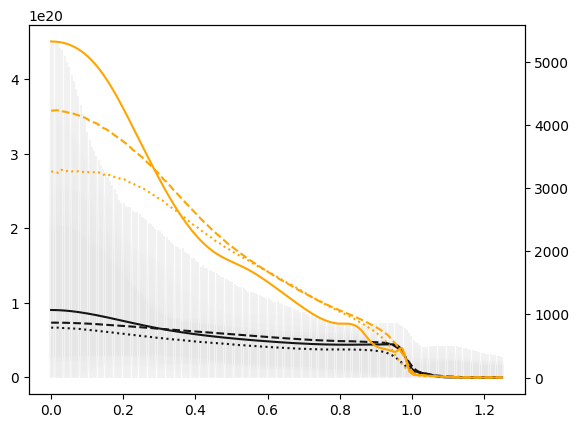

In [44]:
shot_num = train_shots[100]
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shot_num)

_observations, _obs_encoder, _obs_forward = observation_info
[obs_ls_sample, obs_ls_mu, obs_ls_var],  [trans_ls_sample, trans_ls_mu, trans_ls_var] = latent_space_information

# [obs_ls_sample, obs_ls_mu, obs_ls_var], [trans_ls_sample. trans_ls_mu, trans_ls_var] = latent_space_information
print(_observations.shape, trans_ls_mu.shape, radius.shape, obs_ls_mu.shape)

with torch.no_grad(): 
    _obs_mean_enc = model_interface.infer_from_state(obs_ls_mu.unsqueeze(1))
    _obs_mean_enc = data_interface.dataset.denorm_profs(_obs_mean_enc).squeeze(1)

    N_SAMPLES = 100
    samples = torch.distributions.Normal(obs_ls_mu, obs_ls_var).sample((N_SAMPLES,)).reshape(-1, N_SAMPLES, obs_ls_mu.shape[-1])
    print(samples.shape, obs_ls_mu.unsqueeze(1).shape)
    _obs_samples_enc = model_interface.infer_from_state(samples)# .unsqueeze(1)
    _obs_samples_enc = data_interface.dataset.denorm_profs(_obs_samples_enc)# .squeeze(1)


print(_obs_mean_enc.shape, _obs_samples_enc.shape)
fig, axs = plt.subplots()

t_axs = axs.twinx()
t_idx = 100

axs.plot(radius, _observations[t_idx, 0], color='black')
t_axs.plot(radius, _observations[t_idx, 1], color='orange')

axs.plot(radius, _obs_encoder[t_idx, 0], ls='--', color='black')
t_axs.plot(radius, _obs_encoder[t_idx, 1], color='orange', ls='--')


axs.plot(radius, _obs_mean_enc[t_idx, 0], ls=':', color='black')
t_axs.plot(radius, _obs_mean_enc[t_idx, 1], color='orange', ls=':')

axs.plot(np.expand_dims(radius, 1).repeat(N_SAMPLES, 1).T, _obs_samples_enc[t_idx, :, 0], color='grey', alpha=0.1)

plt.show()


torch.Size([248, 1000, 9]) torch.Size([248, 1000, 2, 200])


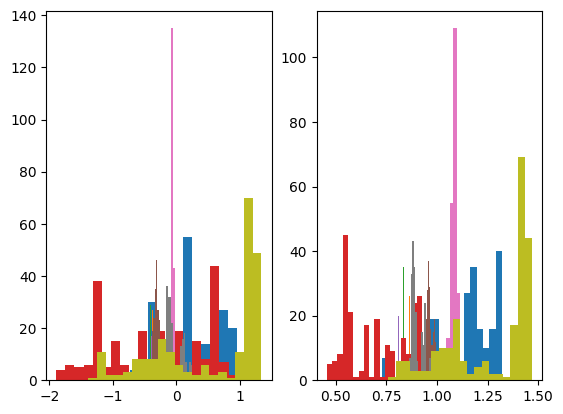

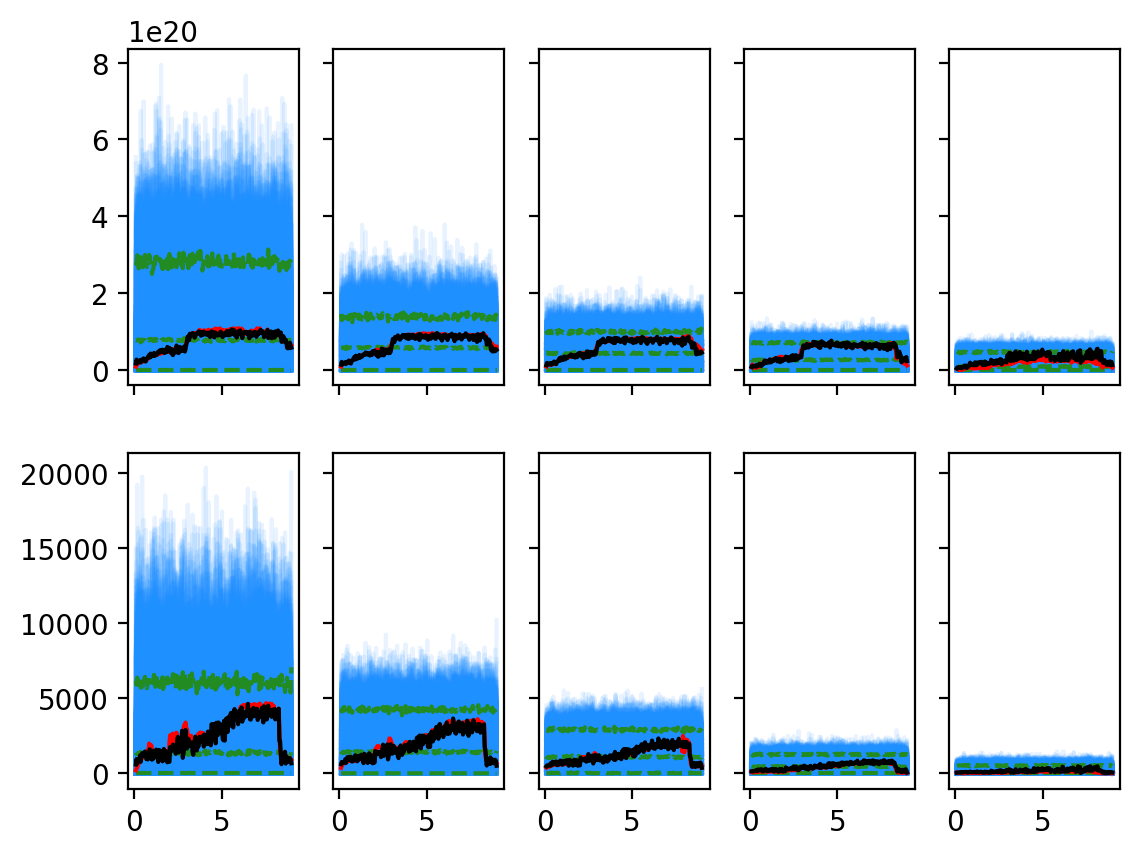

In [40]:
shot_num = test_shots[100]
batch_on_device = get_batch_on_device(shot_num)
if m_interface in [M.DIVA, M.vae]: 
    observations, actions, radii, time = batch_on_device
    actions_cond, actions_cond_recon = [], []
elif m_interface in  [None]: 
    observations, actions, radii, time, actions_cond = batch_on_device 
    
batch_terminus = time > 0

with torch.no_grad():
    observations_out = model_interface.forward_observational(observations, actions)

if m_interface == M.DIVA: 
    [observations_recons, action_recons, [state_obs, state_mu_obs, state_std_devs_obs]], [observation_reconstructions_prior, action_reconstructions_prior, [prior_state, prior_state_locs, prior_state_scales]] = observations_out # model_interface.inference_all(observations, actions)
elif m_interface == M.vae: 
    observations_recons, [state_obs, state_mu_obs, state_std_devs_obs] = observations_out

N_SAMPLES = 1000 
T = batch_terminus.sum() -1
with torch.no_grad():
    samples = torch.distributions.Normal(state_mu_obs, state_std_devs_obs).sample((N_SAMPLES,)).reshape(time.shape[0], N_SAMPLES, state_mu_obs.shape[-1])
    observations_recons_samples = model_interface.infer_from_state(samples)
print(samples.shape, observations_recons_samples.shape)
# print(state_mu_obs.shape)


""" Denormilzation """
_observations = data_interface.dataset.denorm_profs(observations)[:batch_terminus.sum()]
_observations_recons = data_interface.dataset.denorm_profs(observations_recons)[:batch_terminus.sum()]
_observations_recons_samples = data_interface.dataset.denorm_profs(observations_recons_samples)[:batch_terminus.sum()]

data_x = radii[:batch_terminus.sum()].squeeze()[0]
data_time = time[:batch_terminus.sum()].squeeze()

""" Plots """

fig, axs = plt.subplots(1, 2) 

for ls_idx in range(state_obs.shape[-1]): 
    axs[0].hist(state_mu_obs[:batch_terminus.sum(), 0, ls_idx], bins=20, label=f'z-{ls_idx}')
    axs[1].hist(state_std_devs_obs[:batch_terminus.sum(), 0, ls_idx], bins=20, label=f'z-{ls_idx}')
plt.show()

rhos_to_plot = [0.0, 0.3, 0.5, 0.9, 1.0]
fig, axs = plt.subplots(2, len(rhos_to_plot), sharex=True, dpi=200, sharey='row')
for col_idx, rho in enumerate(rhos_to_plot): 
    rho_idx = np.argmin(abs(data_x - rho))
    for i in [0, 1]: 
        axs[i, col_idx].plot(data_time, _observations[:, 0, i, rho_idx], color='red', zorder=25)
        axs[i, col_idx].plot(data_time, _observations_recons[:, 0, i, rho_idx], color='black', zorder=25)
        axs[i, col_idx].plot(data_time.repeat(N_SAMPLES, 1).T, _observations_recons_samples[:, :, i, rho_idx], color='dodgerblue', zorder=5, alpha=0.1)
        q = torch.Tensor([0.05, 0.5, 0.95]).double()
        quants = torch.quantile(_observations_recons_samples[:, :, i, rho_idx], q=q, dim=1)
        for quant_idx, quant in enumerate(q): 
            axs[i, col_idx].plot(data_time, quants[quant_idx], color='forestgreen', ls='--', zorder=20)



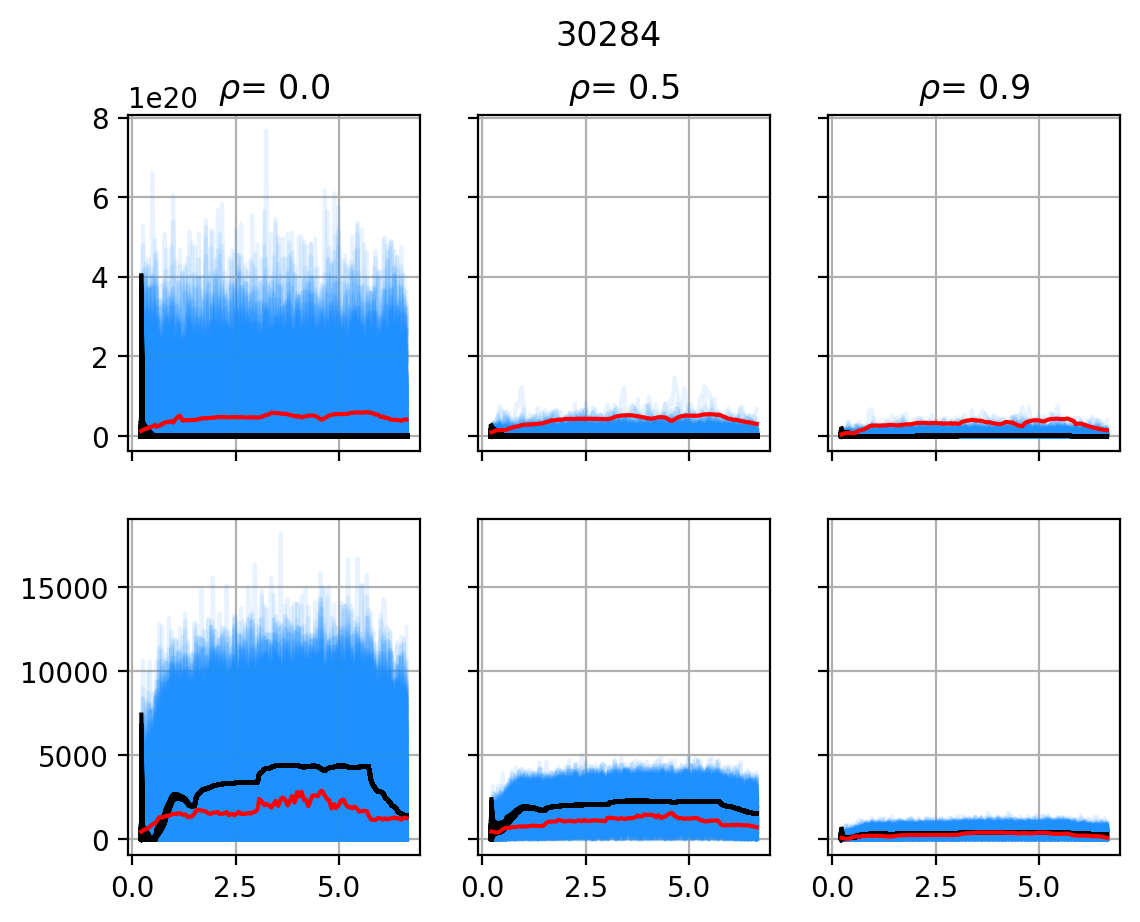

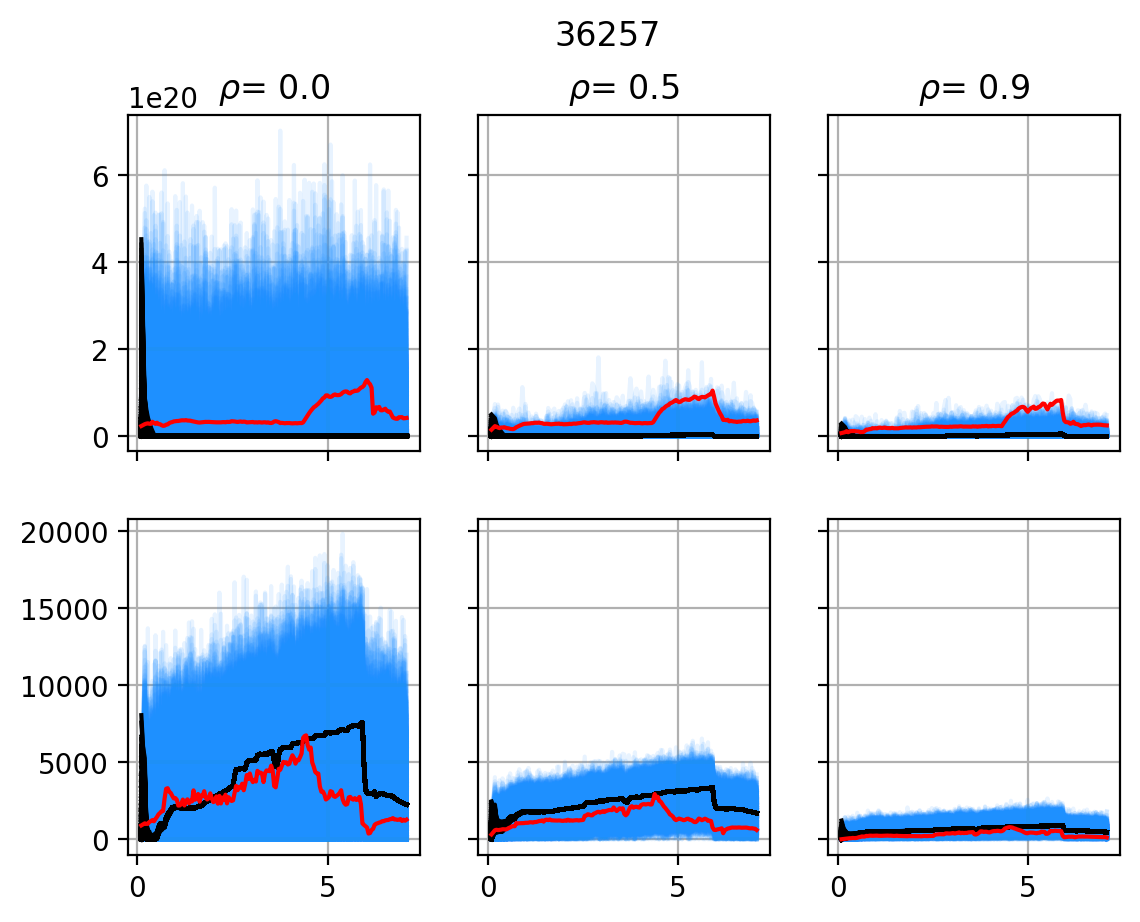

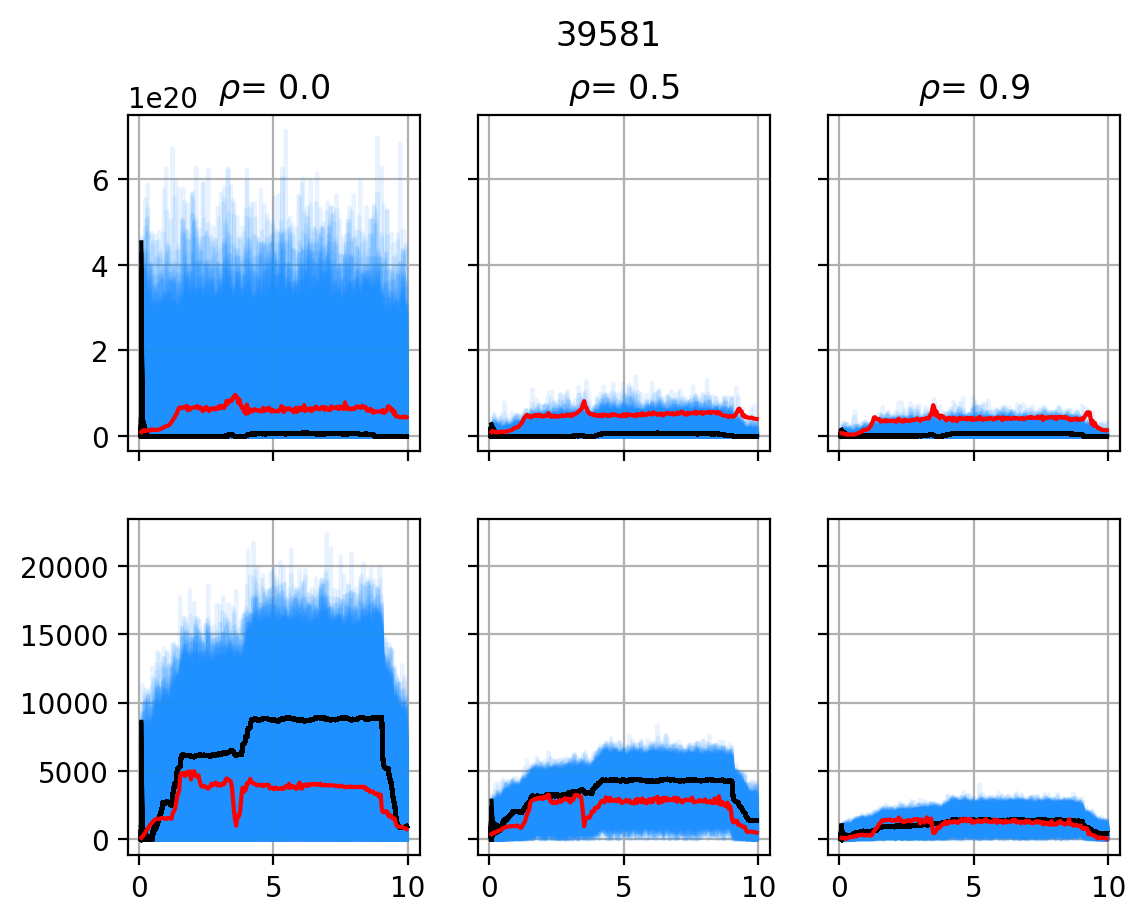

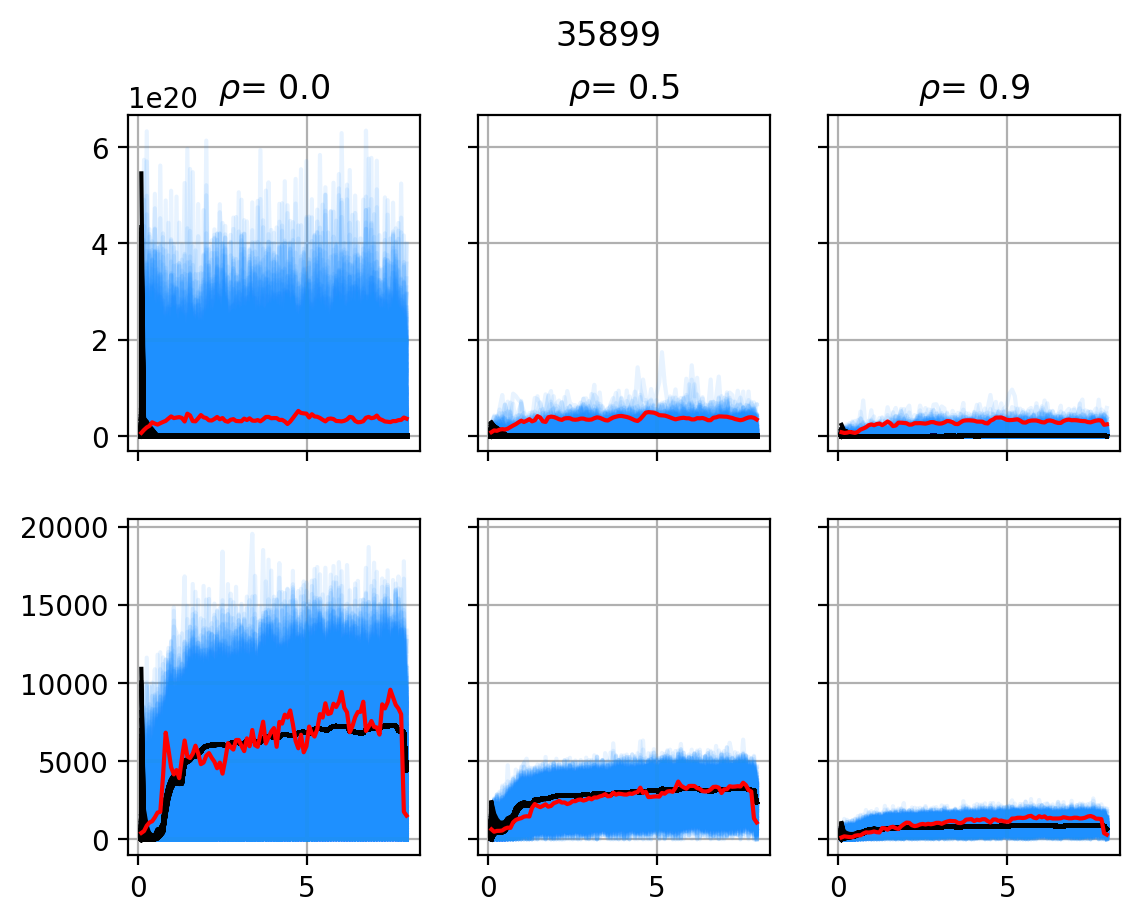

In [9]:
shot_nums = [np.random.choice(test_shots) for i in range(4)]
for shot_num in shot_nums: 
    pred_samp_mean, pred_samp_samp, obs, data_x, data_time = uncertainty_quantification_1(shot_num)
    plot_unc_rollout(pred_samp_mean, pred_samp_samp, obs, data_x, data_time, shot_num)
    

In [ ]:
""" 
ne_width ~ 1 / ne_ped_height
"""

shotno = valid_shots[7]
print(shotno)
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shotno)

data_actions = action_info[0]
[_, post_loc, post_scale], [_, prior_loc, prior_scale] = latent_space_information
data_true, data_pred_obs, data_pred_trans = observation_info
data_time = time 

fig = plt.figure( figsize=(width, 1.5*height), dpi=400)
subfigs = fig.subfigures(1, 2, wspace=0.07)

axs = subfigs[0].subplots(post_loc.shape[-1], sharey=True, sharex=True)
# fig, axs = plt.subplots(post_loc.shape[-1], figsize=(width, 1.5*height), dpi=400)

for i in range(post_loc.shape[-1]): 
    ax = axs[i]
    for loc, scale in [[post_loc, post_scale], [prior_loc, prior_scale]]:
        ax.plot(data_time, loc[:, i])
        ax.fill_between(data_time, loc[:, i] + scale[:, i], loc[:, i] - scale[:, i], alpha=0.3)
    
    ax.label_outer()
    ax.set_ylim(-10, 10)
    ax.set_yticks([-5, 0, 5])
mp_axs = subfigs[1].subplots(data_actions.shape[-1], sharex=True)
for i in range(data_actions.shape[-1]): 
    ax = mp_axs[i]
    ax.plot(data_time, data_actions[:, i], label=mp_name_dict[actions_name_list[i]]['latex'])
    ax.legend(frameon=False)
    

In [ ]:


def to_plot(data_true, data_pred, data_time, data_x, title: str, ): 
    
    hsv_modified = mpl.colormaps.get_cmap('Spectral')
    crange = np.flip(np.linspace(0.1, 1.0, 256), axis=0)
    newcmp = ListedColormap(hsv_modified(crange))
    d_scalar = 1e-19
    t_scalar = 0.001
    fig = plt.figure(figsize=(width, height), dpi=400)
    gs= gridspec.GridSpec(3, 2, height_ratios=[0.5, 4, 4])
    cax_n = plt.subplot(gs[0, 0])
    cax_t = plt.subplot(gs[0, 1])
    ne_ax = plt.subplot(gs[1, 0])
    ne2_ax = plt.subplot(gs[2, 0])
    te_ax = plt.subplot(gs[1, 1])
    te2_ax = plt.subplot(gs[2, 1])


    fig.suptitle(f'AUG \#{shotno} {title}', y=1.0)
    # fig.subplots_adjust(top=0.92)
    # (ne_ax, te_ax), (ne2_ax, te2_ax) = fig.subplots(2, 2)
    ne_minmin, ne_maxmax = min(abs(np.min(data_pred[:, 0, :].numpy()*d_scalar)), abs(np.min(data_true[:, 0, :].numpy()*d_scalar))), max(np.max(data_pred[:, 0, :].numpy()*d_scalar), np.max(data_true[:, 0, :].numpy()*d_scalar))
    te_minmin, te_maxmax = min(np.min(data_true[:, 1, :].numpy()*t_scalar), np.min(data_pred[:, 1, :].numpy()*t_scalar)), max(np.max(data_true[:, 1, :].numpy()*t_scalar), np.max(data_pred[:, 1, :].numpy()*t_scalar))

    ne_plot = ne_ax.imshow(np.swapaxes(data_true[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbars = []
    cbar = fig.colorbar(ne_plot, cax=cax_n, label=' $n_e$ ($10^{19}$m$^{-3}$)', orientation='horizontal', ) # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    # cbar.ax.xaxis.set_label_position('top')
    # cbar.ax.xaxis.set_ticks_position('top')
    te_plot = te_ax.imshow(np.swapaxes(data_true[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbar = fig.colorbar(te_plot, cax=cax_t, label=' $T_e$(keV)', orientation='horizontal') # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)

    for cbar in cbars: 
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        cbar.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    ne2_plot = ne2_ax.imshow(np.swapaxes(data_pred[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    te2_plot = te2_ax.imshow(np.swapaxes(data_pred[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    fig.subplots_adjust(hspace=0.0)
    # ne_ax.set_title(' $n_e$ (m$^{-3}$)')
    # te_ax.set_title(' $T_e$ (eV)')
    xticks = np.array(ne_ax.get_xticks())
    xticks = np.array([int(x) for x in xticks if 0 <= x < time.shape[0]]) # + [data_time.shape[0] - 1]

    yticks = np.array(ne_ax.get_yticks())
    yticks = np.array([int(y) for y in yticks if 0 <= y < data_x.shape[0]]) # + [data_x.shape[0] - 1]

    for ax in [ne_ax, te_ax, ne2_ax, te2_ax]:
        ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))    
        ax.label_outer()
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        # set_ticks(ax, xticks, data_time, yticks, data_x, x_name='time (s)', y_name=r'$\rho$', )  # set tick labels
        ax.set_yticks([0.0, 0.5, 0.9])


    te_ax.set_yticklabels([])
    te_ax.set_xticklabels([])
    ne_ax.set_xticklabels([])
    ne2_ax.set_xlabel('time (s)')
    te2_ax.set_xlabel('time (s)')
    ne_ax.set_ylabel('True \n' +  r'$\rho$')
    ne2_ax.set_ylabel('Recon. \n' r'$\rho$')

    fig.subplots_adjust(hspace=0.11, top=0.8, wspace=0.3)

    plt.show()


    loss = torch.nn.functional.l1_loss(data_true, data_pred_obs, reduction='none')
    loss[:, 0] = loss[:, 0]*1e-19
    loss[:, 1] = loss[:, 1] / 1000.0
    print('Density Mean', loss[:, 0].mean().item(), loss[:, 0].std().item())
    print('Tempearutre Mean', loss[:, 1].mean().item(), loss[:, 1].std().item())
    for rho in [0.0, 0.5, 0.9, 1.0]: 
        rho_idx = np.argmin(abs(data_x - rho))
        print(f'Density {rho}', loss[:, 0, rho_idx].mean().item(), loss[:, 0, rho_idx].std().item())
        print(f'Temperature {rho}', loss[:, 1, rho_idx].mean().item(), loss[:, 1, rho_idx].std().item())


def to_plot2(data_true, data_pred, data_time, data_x, title: str, ): 
    hsv_modified = mpl.colormaps.get_cmap('Spectral')
    crange = np.flip(np.linspace(0.1, 1.0, 256), axis=0)
    newcmp = ListedColormap(hsv_modified(crange))
    d_scalar = 1e-19
    t_scalar = 0.001
    fig = plt.figure(figsize=(width, height), dpi=400)
    fig.suptitle(f'AUG \#{shotno} {title}', y=1.05)
    gs= gridspec.GridSpec(4, 2, height_ratios=[0.5, 4, 4, 4])
    cax_n = plt.subplot(gs[0, 0])
    cax_t = plt.subplot(gs[0, 1])
    ne_ax = plt.subplot(gs[1, 0])
    ne2_ax = plt.subplot(gs[2, 0])
    ne3_ax = plt.subplot(gs[3, 0])
    te_ax = plt.subplot(gs[1, 1])
    te2_ax = plt.subplot(gs[2, 1])
    te3_ax = plt.subplot(gs[3, 1])

    ne_minmin, ne_maxmax = min(abs(np.min(data_pred[:, 0, :].numpy()*d_scalar)), abs(np.min(data_true[:, 0, :].numpy()*d_scalar))), max(np.max(data_pred[:, 0, :].numpy()*d_scalar), np.max(data_true[:, 0, :].numpy()*d_scalar))
    te_minmin, te_maxmax = min(np.min(data_true[:, 1, :].numpy()*t_scalar), np.min(data_pred[:, 1, :].numpy()*t_scalar)), max(np.max(data_true[:, 1, :].numpy()*t_scalar), np.max(data_pred[:, 1, :].numpy()*t_scalar))

    ne_plot = ne_ax.imshow(np.swapaxes(data_true[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbars = []
    cbar = fig.colorbar(ne_plot, cax=cax_n, label=' $n_e$ ($10^{19}$m$^{-3}$)', orientation='horizontal', ) # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    te_plot = te_ax.imshow(np.swapaxes(data_true[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbar = fig.colorbar(te_plot, cax=cax_t, label=' $T_e$(keV)', orientation='horizontal') # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    for cbar in cbars: 
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        cbar.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    ne2_plot = ne2_ax.imshow(np.swapaxes(data_pred[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    te2_plot = te2_ax.imshow(np.swapaxes(data_pred[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    fig.subplots_adjust(hspace=0.0)
    xticks = np.array(ne_ax.get_xticks())
    xticks = np.array([int(x) for x in xticks if 0 <= x < data_time.shape[0]]) # + [data_time.shape[0] - 1]

    yticks = np.array(ne_ax.get_yticks())
    yticks = np.array([int(y) for y in yticks if 0 <= y < data_x.shape[0]]) # + [data_x.shape[0] - 1]


    rho_lns = []
    rho_lns_pred = []
    for rho in [0.0, 0.5, 0.9]: 
        rho_idx = np.argmin(abs(data_x - rho))
        ne_ln, = ne3_ax.plot(data_time, data_true[:, 0, rho_idx]*d_scalar, label=f'{rho:.1}', alpha=0.7)
        ne_ln_pred, = ne3_ax.plot(data_time, data_pred[:, 0, rho_idx]*d_scalar, ls='dotted', c=ne_ln.get_color())
        rho_lns.append(ne_ln)
        rho_lns_pred.append(ne_ln_pred)
        te_ln, = te3_ax.plot(data_time, data_true[:, 1, rho_idx]*t_scalar, label=f'{rho:.1}', alpha=0.7)
        te3_ax.plot(data_time, data_pred[:, 1, rho_idx]*t_scalar, ls='dotted', c=te_ln.get_color())

    for ax in [ne3_ax, te3_ax]: 
        ax.set_xlim(data_time.min(), data_time.max())
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))  
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        
        ax.yaxis.grid(False)
    for cbar, ax in zip(cbars, [ne3_ax, te3_ax]): 
        new_yticks= cbar.get_ticks()
        ax.yaxis.set_ticks(new_yticks)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    for ax in [ne_ax, te_ax, ne2_ax, te2_ax]:
        ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))    
        ax.label_outer()
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.set_yticks([0.0, 0.5, 0.9])
    te_ax.set_yticklabels([])
    te_ax.set_xticklabels([])
    ne_ax.set_xticklabels([])
    ne_ax.yaxis.grid(True, ls='-')
    te_ax.yaxis.grid(True, ls='-')
    te2_ax.yaxis.grid(True, ls='dotted')
    ne2_ax.yaxis.grid(True, ls='dotted')
    ne3_ax.set_xlabel('time (s)')
    te3_ax.set_xlabel('time (s)')
    ne_ax.set_ylabel('True \n' + r'$\rho$')
    ne2_ax.set_ylabel('Forward \n' + r'$\rho$')
    fig.subplots_adjust(hspace=0.11, top=0.8, wspace=0.4)
    ne3_ax.set_ylabel('$10^{19}$m$^{-3}$', labelpad=0.5) # ($10^{19}$m$^{-3}$)
    te3_ax.set_ylabel('keV', labelpad=0.1)
    te3_ax.legend(handles = [*rho_lns], labels=['0', '0.5', '0.9'], title=r'$\rho$', bbox_to_anchor=(0.95, 1.4), frameon=False, labelspacing=0.2, handlelength=1.0, alignment='center')
    plt.show()

    loss = torch.nn.functional.l1_loss(data_true, data_pred, reduction='none')
    loss[:, 0] = loss[:, 0]*1e-19
    loss[:, 1] = loss[:, 1] / 1000.0
    print('Density Mean', loss[:, 0].mean().item(), loss[:, 0].std().item())
    print('Tempearutre Mean', loss[:, 1].mean().item(), loss[:, 1].std().item())
    for rho in [0.0, 0.5, 0.9, 1.0]: 
        rho_idx = np.argmin(abs(data_x - rho))
        print(f'Density {rho}', '{:.3}'.format(loss[:, 0, rho_idx].mean().item()), '\pm{:.3}'.format(loss[:, 0, rho_idx].std().item()))
        print(f'Temperature {rho}', '{:.3}'.format(loss[:, 1, rho_idx].mean().item()), '\pm{:.3}'.format(loss[:, 1, rho_idx].std().item()))
        print()

In [ ]:
shotno = train_shots[10]
print(shotno)
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shotno)

data_true, data_pred_obs, data_pred_trans = observation_info
data_x = radius
data_time = time 

to_plot2(data_true, data_pred_obs, data_time, data_x, 'Observation Recon')
to_plot2(data_true, data_pred_trans, data_time, data_x, 'Forward Recon')
